# Accented Speech Technical Assessment

## DataLoading and Audio File Conversion

In [404]:
import kagglehub
import numpy as np
import os
import pandas as pd
from pydub import AudioSegment
import torchaudio
from tqdm import tqdm

def fetch_dataset():
    accent_dataset_path = kagglehub.dataset_download("rtatman/speech-accent-archive")
    csv_path = os.path.join(accent_dataset_path, 'speakers_all.csv')
    recordings_path = os.path.join(accent_dataset_path, 'recordings/recordings/')
    passage_path = os.path.join(accent_dataset_path, 'reading-passage.txt')

    speakers_df = pd.read_csv(csv_path)
    with open(passage_path, 'r') as f:
        passage = f.read()

    for root, dirs, files in os.walk(recordings_path):
        wavs_dir = recordings_path + 'wavs'
        if not os.path.exists(wavs_dir):
            os.mkdir(wavs_dir)
            for filename in tqdm(files):
                mp3_path = os.path.join(root, filename)
                wav_filename = filename[:-3] + 'wav'
                wav_path = os.path.join(wavs_dir, wav_filename)
                if filename[-3:] == 'mp3':
                    _convert_mp3_to_wav(mp3_path, wav_path=wav_path)

    return speakers_df, passage, wavs_dir

def _convert_mp3_to_wav(mp3_path, wav_path):
    audio = AudioSegment.from_mp3(mp3_path)
    audio = audio.set_frame_rate(16000).set_channels(1)
    audio.export(wav_path, format="wav")

df, passage, wavs_dir = fetch_dataset()

## Looking at the Dataset

In [2]:
df = df.drop(columns=["Unnamed: 9", "Unnamed: 10", "Unnamed: 11"], 
             errors="ignore") # Removing unnecessary columns
df.head(3)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2172 entries, 0 to 2171
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2172 non-null   float64
 1   age_onset        2172 non-null   float64
 2   birthplace       2168 non-null   object 
 3   filename         2172 non-null   object 
 4   native_language  2172 non-null   object 
 5   sex              2172 non-null   object 
 6   speakerid        2172 non-null   int64  
 7   country          2167 non-null   object 
 8   file_missing?    2172 non-null   bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 138.0+ KB


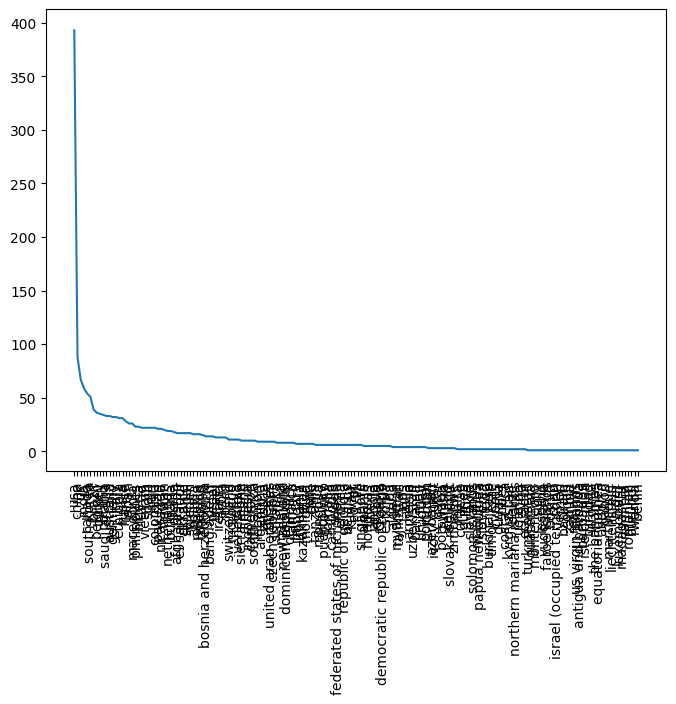

In [448]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.xticks(rotation=90)
plt.plot(df['country'].value_counts())

## Looking at the Model

In [7]:
import torch
import torchaudio
from speechbrain.inference.interfaces import foreign_class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = foreign_class(source="warisqr7/accent-id-commonaccent_xlsr-en-english", pymodule_file="custom_interface.py", classname="CustomEncoderWav2vec2Classifier")
classifier.to(device)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'warisqr7/accent-id-commonaccent_xlsr-en-english' if not cached
INFO:speechbrain.utils.fetching:Fetch custom_interface.py: Fetching from HuggingFace Hub 'warisqr7/accent-id-commonaccent_xlsr-en-english' if not cached
INFO:speechbrain.utils.fetching:Fetch wav2vec2.ckpt: Fetching from HuggingFace Hub 'Jzuluaga/accent-id-commonaccent_xlsr-en-english' if not cached
INFO:speechbrain.utils.fetching:Fetch model.ckpt: Fetching from HuggingFace Hub 'Jzuluaga/accent-id-commonaccent_xlsr-en-english' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'Jzuluaga/accent-id-commonaccent_xlsr-en-english' if not cached
INFO:speechbrain.u

CustomEncoderWav2vec2Classifier(
  (mods): ModuleDict(
    (wav2vec2): Wav2Vec2(
      (model): Wav2Vec2Model(
        (feature_extractor): Wav2Vec2FeatureEncoder(
          (conv_layers): ModuleList(
            (0): Wav2Vec2LayerNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
              (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (activation): GELUActivation()
            )
            (1-4): 4 x Wav2Vec2LayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
              (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (activation): GELUActivation()
            )
            (5-6): 2 x Wav2Vec2LayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
              (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (activation): GELUActivation()
            )
          )
        

## Predicting classes on the dataset and extracting embeddings

In [8]:
import pickle
data = {}

for root, dirs, files in os.walk(wavs_dir):
    for f in tqdm(files):
        audio = torchaudio.load(os.path.join(root, f))
        prediction = classifier.classify_batch(audio[0])
        encoding = classifier.encode_batch(audio[0])
        data[f[:-4]] = (encoding, prediction)

with open('data.pkl', 'wb') as pickle_file:
    data = pickle.dump(pickle_file)

100%|██████████| 2138/2138 [2:11:57<00:00,  3.70s/it]  


In [433]:
import pickle
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [442]:
encodings = {}
joiner = []

for k, v in data.items():
    
    filename = k
    encoding = v[0]
    prediction = v[1]
    prediction_confidence = v[1][1][0].numpy()
    prediction_label = prediction[3][0]
    joiner.append({
        'filename': filename,
        'confidence': np.float64(prediction_confidence),
        'prediction': prediction_label,
    })
    
    encodings[k] = encoding
df_to_join = pd.DataFrame(joiner)
df_pred = pd.merge(df, df_to_join, on='filename')


In [443]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_pred['filipino'] = df_pred['country'] == 'philippines'
df_pred['encoded_label'] = le.fit_transform(df_pred['filipino']) 
df_pred['encoded_prediction'] = le.transform(df_pred['prediction'] == 'philippines') 

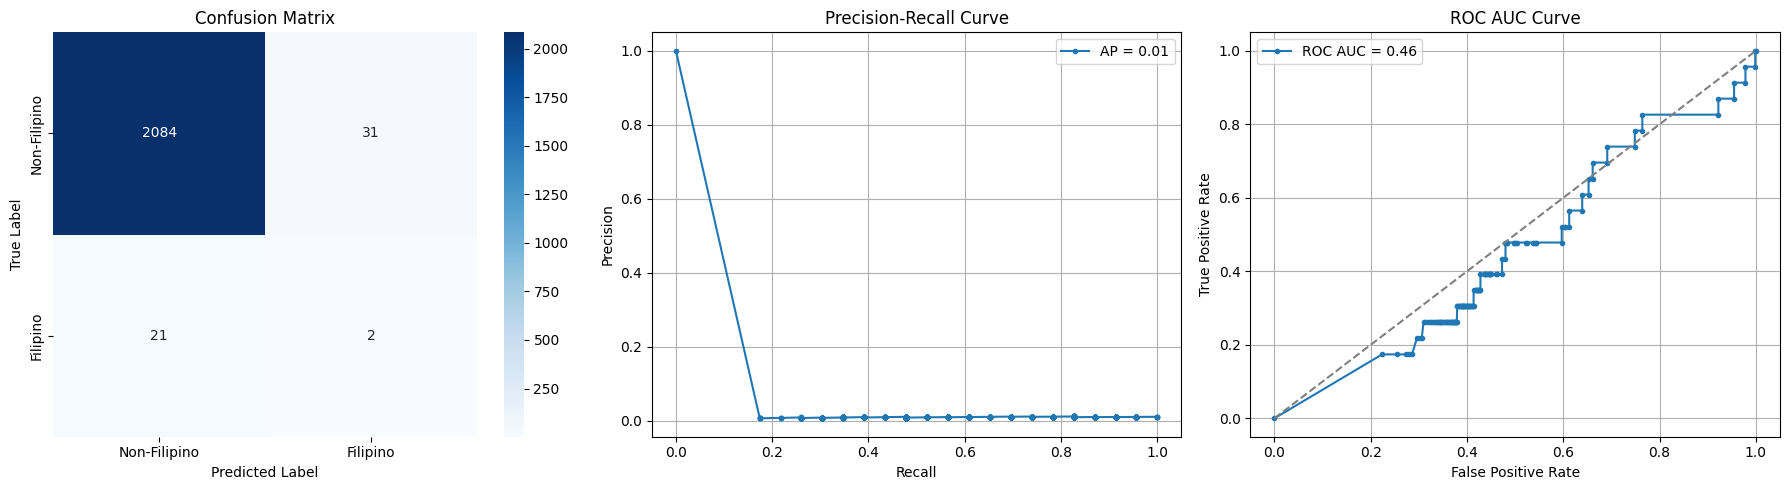

In [444]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_curve, 
    roc_curve, 
    auc, 
    average_precision_score
)

y_true = df_pred['encoded_label']
y_pred = df_pred['encoded_prediction']
y_scores = df_pred['confidence']

cm = confusion_matrix(y_true, y_pred) 

precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Filipino', 'Filipino'], 
            yticklabels=['Non-Filipino', 'Filipino'], ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

# Plot Precision-Recall Curve
ax[1].plot(recall, precision, marker='.', label=f'AP = {ap_score:.2f}')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve')
ax[1].legend()
ax[1].grid()

# Plot ROC Curve
ax[2].plot(fpr, tpr, marker='.', label=f'ROC AUC = {roc_auc:.2f}')
ax[2].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')
ax[2].set_title('ROC AUC Curve')
ax[2].legend()
ax[2].grid()

plt.tight_layout()
plt.show()


## Visualizing the data

In [445]:
viz_list = []
for k, v in encodings.items():
    filename = k
    embedding = v[0].numpy()
    label = df_pred['encoded_label'].loc[df_pred['filename'] == k]
    viz_list.append({
        'embedding': embedding,
        'label': label.iloc[0]
    })
df_viz = pd.DataFrame(viz_list)

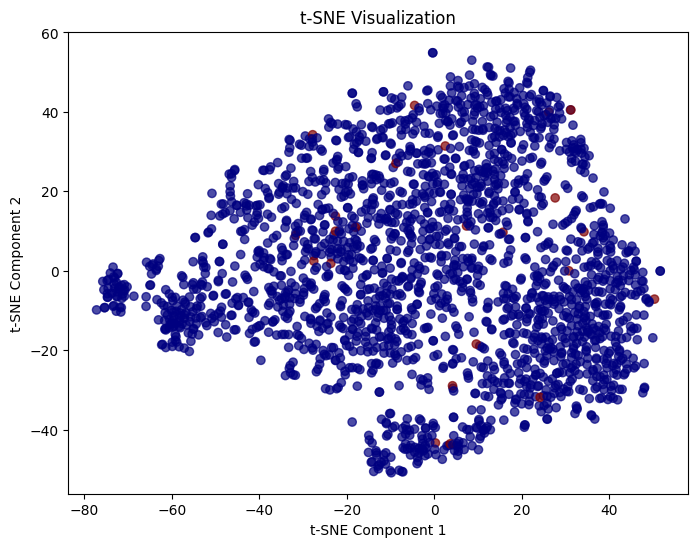

In [447]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_embedded = tsne.fit_transform(np.vstack(df_viz['embedding'].values))

plt.figure(figsize=(8, 6))
scatter_tsne = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_viz['label'], cmap="jet", alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.show()